# Graph Analysis

## 1. Project Setup & Environment

In [7]:
# Install & configure dependencies
!pip install pyspark
!pip install graphframes

In [16]:
# spark functionality
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, count, lit, year, month, split, explode, size, regexp_replace, trim, row_number, rand
from pyspark.ml.feature import StringIndexer # incoding strings
from pyspark.ml.evaluation import RegressionEvaluator # for evaluation
from graphframes import GraphFrame # for graphs
from pyspark.sql.window import Window

# for visualizations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from networkx.algorithms import bipartite # for bipartite

In [9]:
# initialize SparkSession with GraphFrames support
spark = SparkSession.builder \
    .appName("YelpEDA_GraphAnalysis") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.1-s_2.12") \
    .getOrCreate()

# verify the session
spark

## 2. Data Ingestion

In [10]:
business_df = spark.read.json("/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json") \
    .select("business_id", "name", "categories")
user_df = spark.read.json("/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json") \
    .select("user_id", "name", "review_count", "average_stars", "friends")
review_df = spark.read.json("/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json") \
    .select("user_id", "business_id", "stars", "date")

25/05/13 16:52:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## 3. Graph Creation

In [11]:
# create vertices for the graphs

# User vertices for friendship graph
target_user_cols = ["user_id", "name", "review_count", "average_stars"]
user_vertices = user_df.selectExpr(
    "user_id as id", 
    "name", 
    "review_count", 
    "average_stars"
)

# Business vertices for review graph
business_vertices = business_df.selectExpr(
    "business_id as id", 
    "name",
    "categories"
)

In [12]:
# combine vertices for the bipartite graph

# we can reuse user_vertices and business_vertices, adding missing columns
u_verts = user_vertices.withColumn("categories", lit(None).cast("string"))
b_verts = business_vertices.withColumn("review_count", lit(None).cast("int")) \
                          .withColumn("average_stars", lit(None).cast("double"))
bipartite_vertices = u_verts.unionByName(b_verts)

In [13]:
# create edges:

# create Friend edges by explode friends of each user after splitting them (User <-> User)
friend_edges = user_df.select(
    col("user_id").alias("src"),
    explode(
        split(trim(col("friends")), ", *")
    ).alias("dst")
).filter(col("dst") != "")

# review edges (User -> Business)
review_edges = review_df.selectExpr(
    "user_id as src", 
    "business_id as dst", 
    "stars as rating", 
    "date"
)

In [14]:
# build the graphs

g_friend = GraphFrame(user_vertices, friend_edges)
g_review = GraphFrame(business_vertices, review_edges)
g_bi = GraphFrame(bipartite_vertices, review_edges)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


## 4. Graph Visulaization

### 4.1 Plot a Small Subset of the User-Friends Graph

In [23]:
# pick 5 low-degree users as seeds for better visuals
low_degree = friend_edges.groupBy("src") \
    .count().withColumnRenamed("count","friend_count") \
    .filter(col("friend_count") <= 10)

seed_users = low_degree.select("src").distinct().limit(10)

# for each seed, take 10 of their friends
one_hop = friend_edges.join(seed_users, "src")
w = Window.partitionBy("src").orderBy(rand())
sample_one_hop = (
    one_hop
    .withColumn("rn", row_number().over(w))
    .filter(col("rn") <= 10)
    .select("src","dst")
)

# build the induced vertex set (seeds + those friends)
vertices = (
    sample_one_hop.select(col("src").alias("id"))
    .union(sample_one_hop.select(col("dst").alias("id")))
    .distinct()
)

# pull in any edges among that vertex set (including friend <-> friend)
sub_edges = (
    friend_edges
    .join(vertices.withColumnRenamed("id","v1"), friend_edges.src == col("v1"))
    .join(vertices.withColumnRenamed("id","v2"), friend_edges.dst == col("v2"))
    .select("src","dst")
)

# map IDs -> names
user_names = user_df.select(col("user_id").alias("id"), col("name"))
named = (
    sub_edges
    .join(user_names, sub_edges.src == user_names.id)
    .select("src","dst", col("name").alias("src_name"))
    .join(
      user_names.withColumnRenamed("id","dst_id")
                .withColumnRenamed("name","dst_name"),
      sub_edges.dst == col("dst_id")
    )
    .select("src_name","dst_name")
)

# collect just this tiny subgraph and plot
pdf = named.toPandas()
Gf = nx.from_pandas_edgelist(pdf, "src_name", "dst_name")

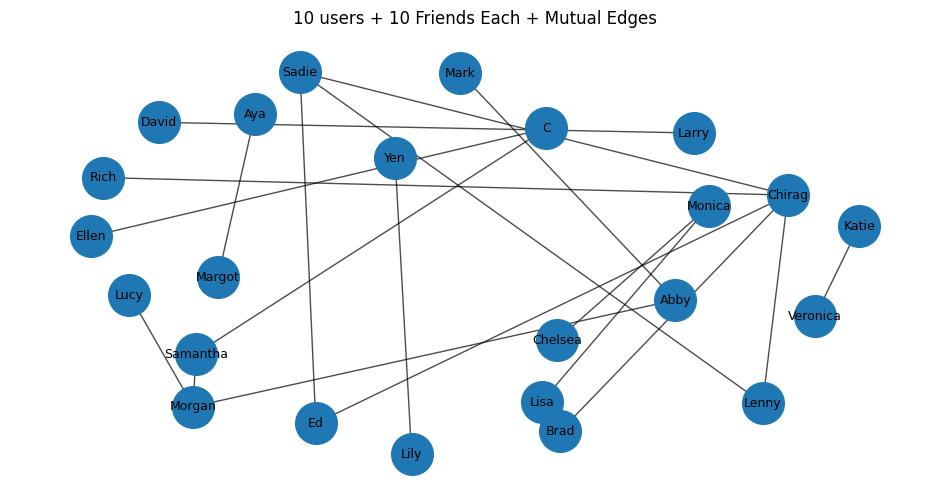

In [54]:
pos = nx.spring_layout(Gf, k=0.8, iterations=10, seed=2)
plt.figure(figsize=(12,6))
nx.draw_networkx_nodes(Gf, pos, node_size=900)
nx.draw_networkx_edges(Gf, pos, alpha=0.7)
nx.draw_networkx_labels(Gf, pos, font_size=9)
plt.title("10 users + 10 Friends Each + Mutual Edges")
plt.axis("off")
plt.show()

### 4.2 Bipartite Plot for Users and Businesses

In [88]:
# pick 5 businesses with more than 2 reviews
biz_pop = (
    review_df.groupBy("business_id").count()
             .filter(col("count") >= 2)
             .orderBy(rand())
             .select(col("business_id"))
             .limit(5)
)

# for each business, sample up to 5 distinct users who reviewed it
rev = review_edges.select(col("src").alias("user_id"), col("dst").alias("business_id"))
biz_window = Window.partitionBy("business_id").orderBy(rand())
sample_ub = (
    rev.join(biz_pop, "business_id")
       .withColumn("rn", row_number().over(biz_window))
       .filter(col("rn") <= 5)
       .select("user_id", "business_id")
       .distinct()
)

# build vertex set (users + businesses)
vb = (
    sample_ub.select(col("user_id").alias("id"))
             .union(sample_ub.select(col("business_id").alias("id")))
             .distinct()
)

# pull in any edges among that vertex set (ensure user–biz edges)
sub_edges = (
    rev.join(vb.withColumnRenamed("id","u"), rev.user_id == col("u"))
       .join(vb.withColumnRenamed("id","b"), rev.business_id == col("b"))
       .select(col("user_id"), col("business_id"))
)

# map IDs → names
users = user_df.select(col("user_id").alias("user_id"), col("name").alias("user_name"))
bizs  = business_df.select(col("business_id"), col("name"))

named = (
    sub_edges
      .join(users, "user_id")
      .join(bizs, "business_id")
      .select("user_name", "name")
)

# also bring the rating into pandas dataframe 
small_rev = (
    review_df
      .join(sub_edges, ["user_id","business_id"])
      .select("user_id","business_id","stars")
)

# map IDs -> names in Spark
named = (
    small_rev
    .join(user_df.select("user_id", col("name").alias("user_name")), "user_id")
    .join(business_df.select("business_id", col("name")), "business_id")
    .select("user_name","name","stars")
)

# now collect
pdf = named.toPandas()

B = nx.Graph()
B.add_nodes_from(pdf["user_name"].unique(), bipartite=0)
B.add_nodes_from(pdf["name"].unique(), bipartite=1)
B.add_edges_from(list(zip(pdf["user_name"], pdf["name"])))

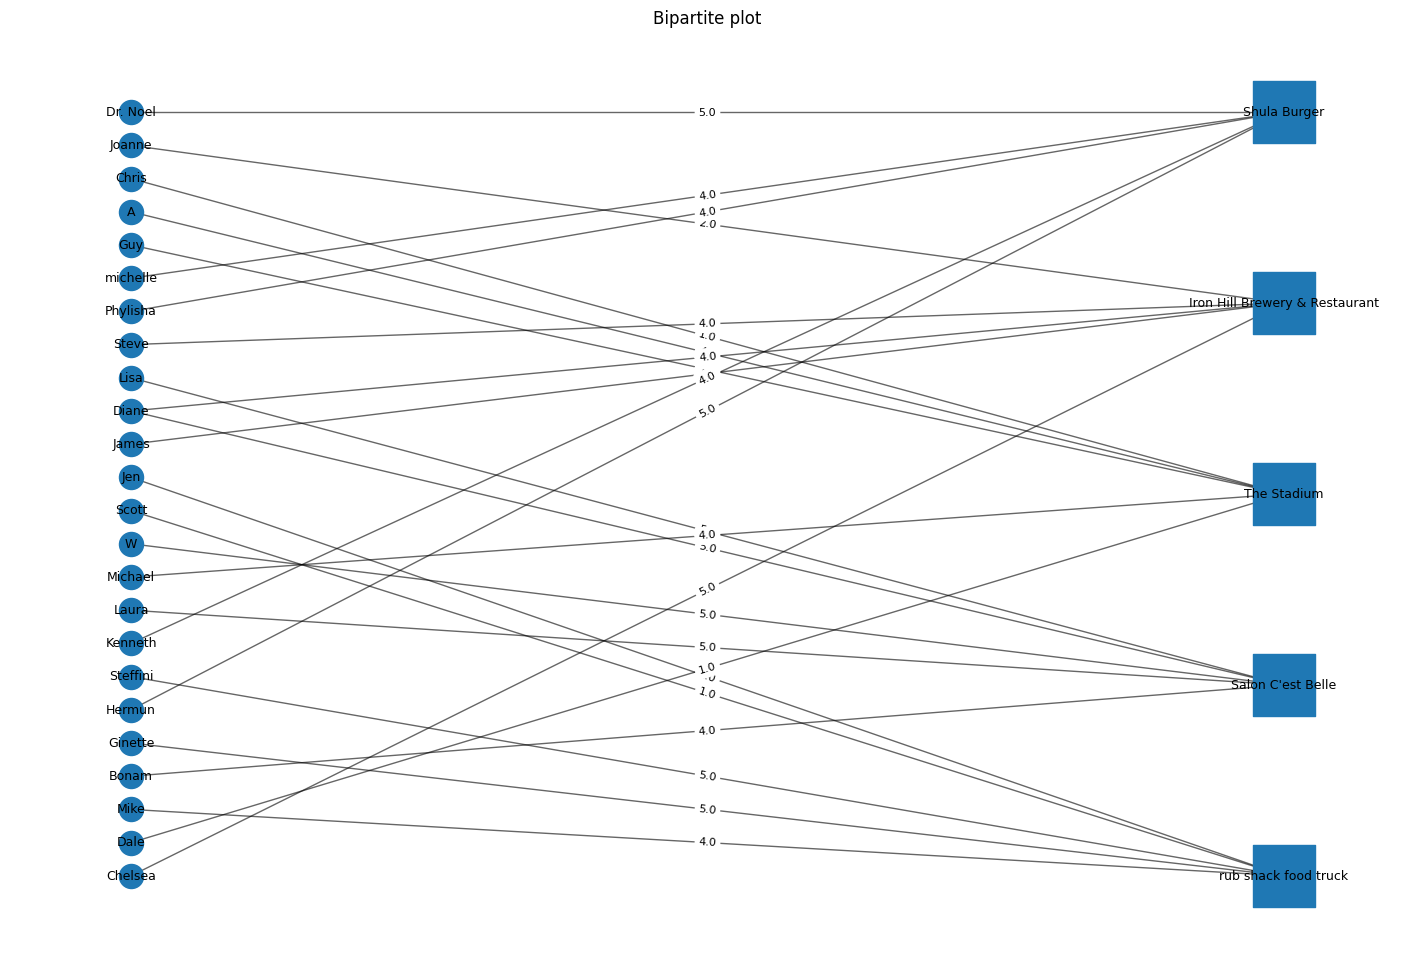

In [104]:
users = pdf['user_name'].unique().tolist()
business = pdf['name'].unique().tolist()

pos = {
    u: (0, 1 - idx/(len(users)-1))
    for idx, u in enumerate(users)
}
pos.update({
    b: (1, 1 - idx/(len(business)-1))
    for idx, b in enumerate(business)
})

edge_labels = {
    (row.user_name, row['name']): row.stars
    for _, row in pdf.iterrows()
}

plt.figure(figsize=(18,12))
nx.draw_networkx_nodes(B, pos, nodelist=users,    node_size=300)
nx.draw_networkx_nodes(B, pos, nodelist=business, node_shape='s', node_size=2000)
nx.draw_networkx_edges(B, pos, alpha=0.6)
nx.draw_networkx_labels(B, pos, font_size=9)
nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels, font_size=8)
plt.title("Bipartite plot")
plt.axis('off')
plt.show()